In [229]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras import layers
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from pymongo import MongoClient
import seaborn as sns

In [230]:
mongo_client = MongoClient('localhost', 27017)

db = mongo_client.crypto
col = db.cryptodataBTC

df = pd.DataFrame(list(col.find()))
df.head()

,_id,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,61099b988eea2a0b11621777,2017-08-17 00:00:00,4261.48,4313.62,4261.32,4308.83,47.18100900,2017-08-17 00:59:59.999,202366.13839304,171,35.16050300,150952.47794304
1,61099b988eea2a0b11621778,2017-08-17 01:00:00,4308.83,4328.69,4291.37,4315.32,23.23491600,2017-08-17 01:59:59.999,100304.82356749,102,21.44807100,92608.27972836
2,61099b988eea2a0b11621779,2017-08-17 02:00:00,4330.29,4345.45,4309.37,4324.35,7.22969100,2017-08-17 02:59:59.999,31282.31266989,36,4.80286100,20795.31722405
3,61099b988eea2a0b1162177a,2017-08-17 03:00:00,4316.62,4349.99,4287.41,4349.99,4.44324900,2017-08-17 03:59:59.999,19241.05829986,25,2.60229200,11291.34701534
4,61099b988eea2a0b1162177b,2017-08-17 04:00:00,4333.32,4377.85,4333.32,4360.69,0.97280700,2017-08-17 04:59:59.999,4239.50358563,28,0.81465500,3552.74681715


In [231]:
df.shape

(34629, 12)

In [232]:
df = df.drop(columns = ['_id', 'Close time'])

In [233]:
df = df.rename(columns ={"Open time":"time"})

In [234]:
df

,time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,2017-08-17 00:00:00,4261.48,4313.62,4261.32,4308.83,47.18100900,202366.13839304,171,35.16050300,150952.47794304
1,2017-08-17 01:00:00,4308.83,4328.69,4291.37,4315.32,23.23491600,100304.82356749,102,21.44807100,92608.27972836
2,2017-08-17 02:00:00,4330.29,4345.45,4309.37,4324.35,7.22969100,31282.31266989,36,4.80286100,20795.31722405
3,2017-08-17 03:00:00,4316.62,4349.99,4287.41,4349.99,4.44324900,19241.05829986,25,2.60229200,11291.34701534
4,2017-08-17 04:00:00,4333.32,4377.85,4333.32,4360.69,0.97280700,4239.50358563,28,0.81465500,3552.74681715
...,...,...,...,...,...,...,...,...,...,...
34624,2021-08-03 15:50:00,38230.02000000,38230.02000000,38230.01000000,38230.02000000,0.23632900,9034.86238758,0.23632900,0.23542900,9000.45537858
34625,2021-08-03 15:51:00,38241.21000000,38241.22000000,38233.08000000,38237.69000000,0.27962600,10692.51638134,0.27962600,0.15226000,5822.11432785
34626,2021-08-03 15:52:00,38221.10000000,38221.10000000,38221.10000000,38221.10000000,0.00487700,186.40430470,0.00487700,0.00000000,0.00000000
34627,2021-08-03 15:53:00,38131.04000000,38131.04000000,38117.25000000,38120.00000000,3.77940600,144075.17837781,3.77940600,1.66943300,63638.76154849


In [235]:
print('The beginning date of the data is {}'.format(df['time'].iloc[0]))
print('The ending date of the data is {}'.format(df['time'].iloc[-1]))

The beginning date of the data is 2017-08-17 00:00:00
The ending date of the data is 2021-08-03 15:54:00


In [236]:
df = df.set_index('time')

In [237]:
df.head(5)

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
time,,,,,,,,,
2017-08-17 00:00:00,4261.48,4313.62,4261.32,4308.83,47.18100900,202366.13839304,171,35.16050300,150952.47794304
2017-08-17 01:00:00,4308.83,4328.69,4291.37,4315.32,23.23491600,100304.82356749,102,21.44807100,92608.27972836
2017-08-17 02:00:00,4330.29,4345.45,4309.37,4324.35,7.22969100,31282.31266989,36,4.80286100,20795.31722405
2017-08-17 03:00:00,4316.62,4349.99,4287.41,4349.99,4.44324900,19241.05829986,25,2.60229200,11291.34701534
2017-08-17 04:00:00,4333.32,4377.85,4333.32,4360.69,0.97280700,4239.50358563,28,0.81465500,3552.74681715


In [238]:
def normalize_data(df1):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df1['Close']=scaler.fit_transform(df1['Close'].values.reshape(-1,1))
    return df1

df_norm = normalize_data(df)
df_norm.shape

(34629, 9)

Text(0.5, 1.0, 'Price of Bitcoin')

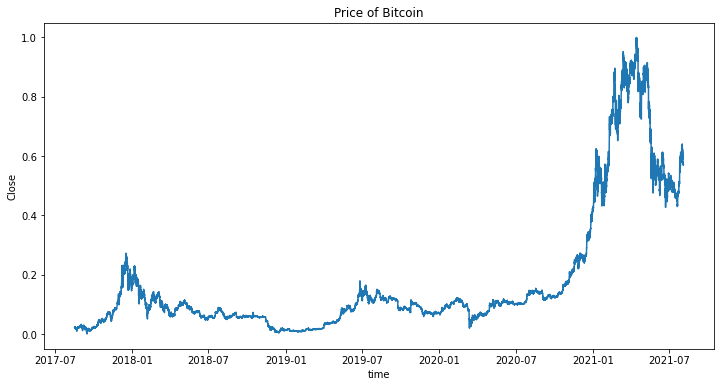

In [239]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y="Close", data=df_norm).set_title("Price of Bitcoin")

In [240]:
data = df.iloc[:, 0]
hist = []
target = []
length = 250
for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [241]:
print(hist[1][249])
print(data[50])
print(target[0])

4312.69
4077.0
4312.69


In [242]:
hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1,1)

In [243]:
hist.shape

(34379, 250)

In [244]:
target.shape

(34379, 1)

In [245]:
sc = MinMaxScaler()
hist_scaled = sc.fit_transform(hist)
target_scaled = sc.fit_transform(target)

In [247]:
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(34379, 250, 1)


In [248]:
X_train = hist_scaled[:33500,:,:]
X_test = hist_scaled[33500:,:,:]
y_train = target_scaled[:33500,:]
y_test = target_scaled[33500:,:]

In [249]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True, input_shape=(250,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True, dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 250, 32)           4352      
_________________________________________________________________
lstm_49 (LSTM)               (None, 250, 32)           8320      
_________________________________________________________________
lstm_50 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [250]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [251]:
history = model.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
524/524 [==============================] - 109s 187ms/step - loss: 0.0055
Epoch 2/3
524/524 [==============================] - 99s 189ms/step - loss: 5.9626e-04
Epoch 3/3
524/524 [==============================] - 95s 181ms/step - loss: 5.0811e-04


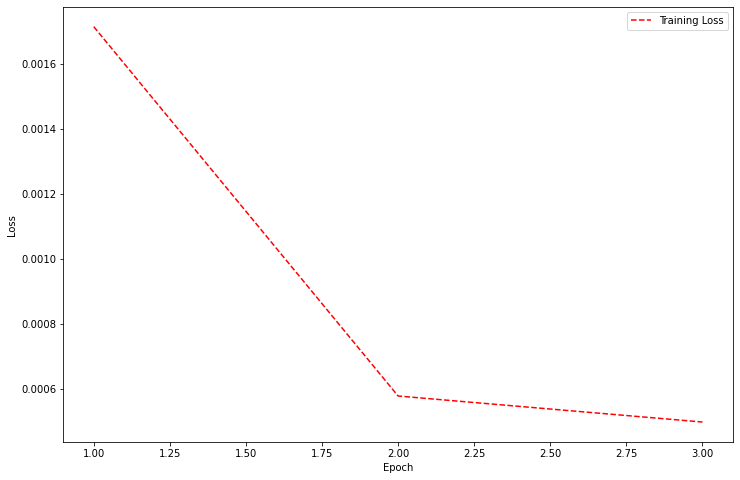

In [252]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

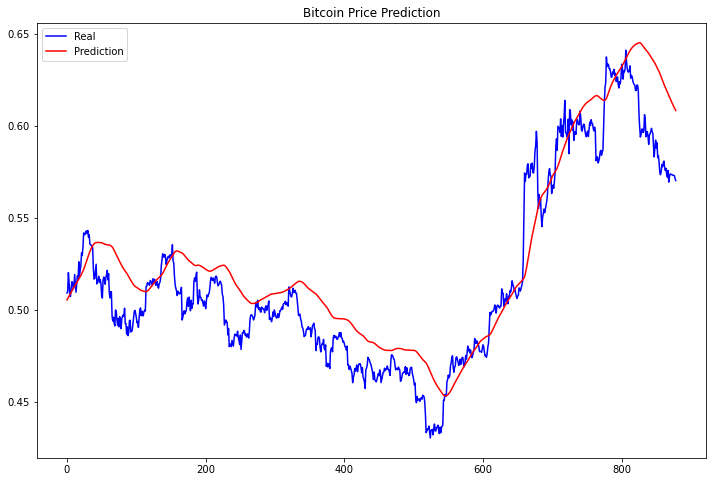

In [253]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()